<a href="https://colab.research.google.com/github/eshaandinesh/Colab/blob/main/milkproductionrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/monthly_milk_production.csv',index_col = 'Date',parse_dates = True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

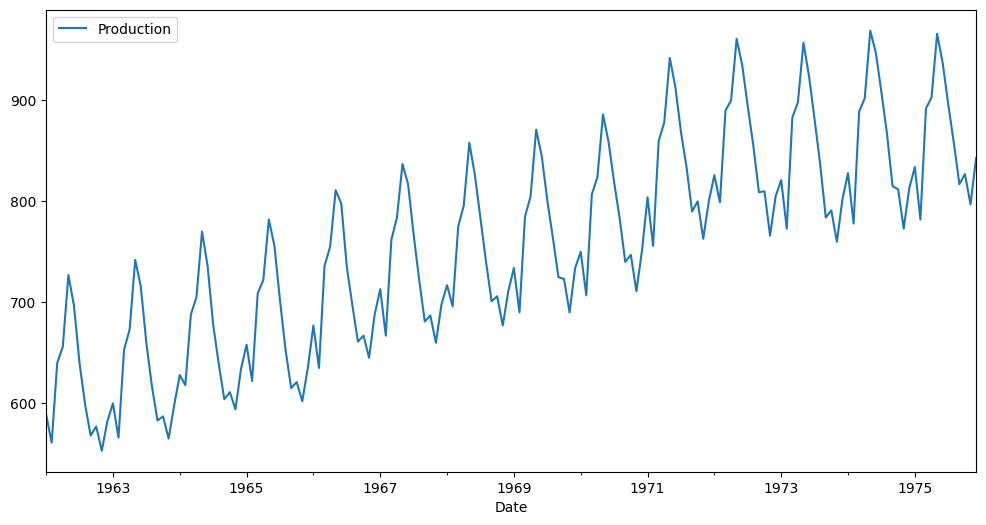

In [ ]:
df.plot(figsize=(12,6))

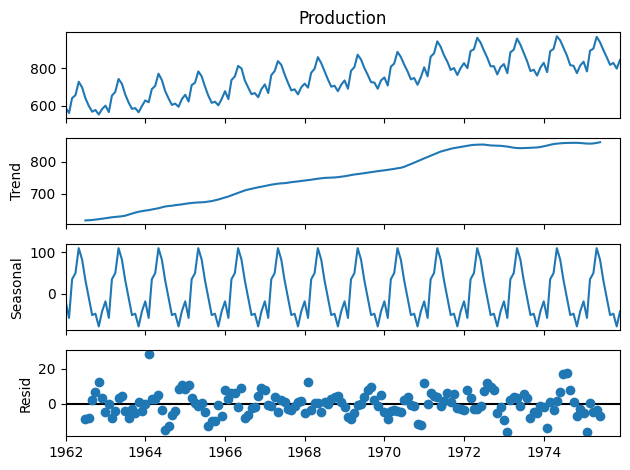

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Production'])
results.plot();

In [ ]:
len(df)

168

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [ ]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam',loss='mse')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=10)

Epoch 1/10
144/144 [==============================] - 4s 15ms/step - loss: 0.0357
Epoch 2/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0231
Epoch 3/10
144/144 [==============================] - 2s 14ms/step - loss: 0.0203
Epoch 4/10
144/144 [==============================] - 3s 20ms/step - loss: 0.0152
Epoch 5/10
144/144 [==============================] - 4s 30ms/step - loss: 0.0131
Epoch 6/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0048
Epoch 7/10
144/144 [==============================] - 4s 29ms/step - loss: 0.0049
Epoch 8/10
144/144 [==============================] - 3s 21ms/step - loss: 0.0037
Epoch 9/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0035
Epoch 10/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0042


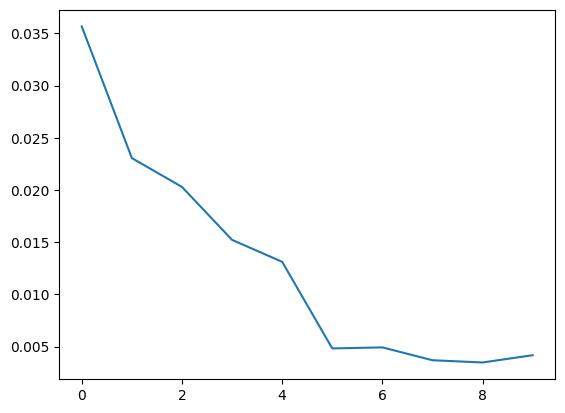

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-12:]
last_train_batch=last_train_batch.reshape((1,n_input,n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 229ms/step


array([[0.58124405]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.67548077])

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [ ]:
test_predictions

[array([0.58124405], dtype=float32),
 array([0.6125397], dtype=float32),
 array([0.70232695], dtype=float32),
 array([0.7836307], dtype=float32),
 array([0.84683526], dtype=float32),
 array([0.8320065], dtype=float32),
 array([0.7779574], dtype=float32),
 array([0.6915188], dtype=float32),
 array([0.615889], dtype=float32),
 array([0.56424874], dtype=float32),
 array([0.5444809], dtype=float32),
 array([0.54895884], dtype=float32)]

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['predictions']= true_predictions

<ipython-input-71-1041d8f373b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions']= true_predictions


<Axes: xlabel='Date'>

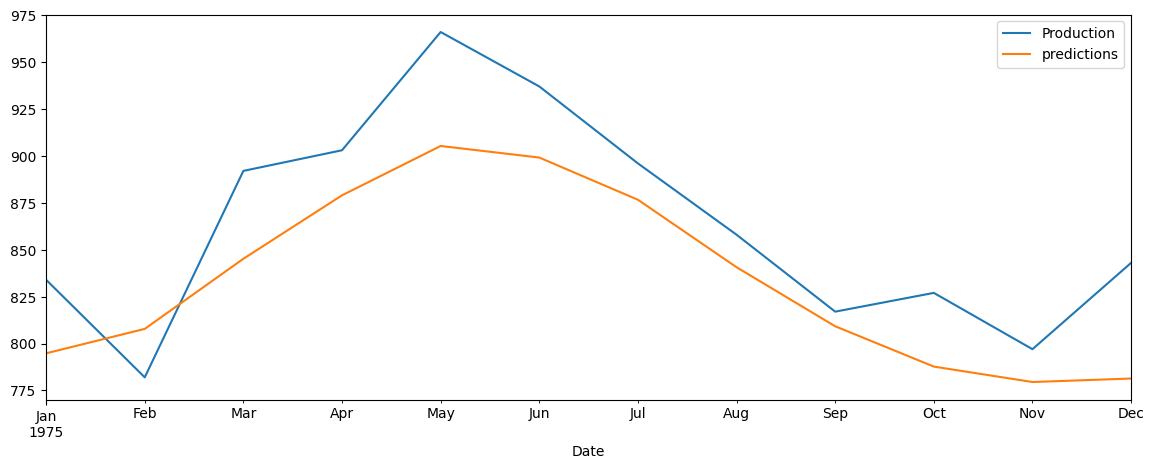

In [ ]:
test.plot(figsize=(14,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Production'],test['predictions']))
print(rmse)

37.05630418120243
